In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from Algos.heuristic_learning import filtering, PR_ranking, K_ranking, node2vec_for_clustering, cluster_describtion
from tqdm import tqdm
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Macro Function

In [16]:
def vector_Clustering_exe(df, PR_index, from_name, to_name, weight_name, from_target_name, to_target_name, K_start, K_end, K_step,
                          seed_strategy = 'both', verbose = False):
    params_names = ['K','nx_density', 'num_nodes', 'num_edges', 'num_seeds', 'expand2seed',
                    'D', 'length', 'walks', 'p', 'q', 'sil_coeff']
    params_data = []
    print('>>> 开始 Vectorized Clustering...')
    for K in tqdm(range(K_start, K_end, K_step)): # 最宏观的参数K
        seed_ids, expanded_ids, target_data = K_ranking(df, PR_index, 
                                                        from_name, to_name, weight_name, from_target_name, to_target_name,
                                                        seed_strategy, K = K)
        num_seed = len(seed_ids)
        expand2seed = np.round(len(expanded_ids) / num_seed, 4)
        if verbose:
            print(f'>>> 取与种子 Top {K} 个最相似的样本时：')
            print('>> 种子数 =',num_seed,'; 实际扩展比 =', expand2seed)
        n2v_clus = node2vec_for_clustering(target_data, from_name, to_name, weight_name = weight_name, verbose = verbose)
        labeled_df = n2v_clus.training()
        labeled_df.to_csv(f'results/Top{K}_n2v_DBSCAN.txt', index = False)
        params_data.append([K, n2v_clus.density, n2v_clus.num_nodes, n2v_clus.num_edges, num_seed, expand2seed,
                            n2v_clus.best_d, n2v_clus.best_walk_length, n2v_clus.best_num_walks,
                            n2v_clus.best_p, n2v_clus.best_q, 
                            n2v_clus.best_score])
    print('>>> Vectorized Clustering done and Each group of data has been saved!')   
    tuning_result = pd.DataFrame(params_data, columns = params_names).sort_values('sil_coeff', ascending = False)
    
    return tuning_result


### Data Preprocess

In [17]:
# DATA UPLOAD
edge_df = pd.read_csv('data/fraud/toy_fraud.csv', parse_dates=[9])
node_df = pd.read_csv('data/fraud/toy_nodes.csv')
edge_df.info(); node_df.info() # 检查数据类型、缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_id    80 non-null     int64         
 1   from_id     80 non-null     object        
 2   to_id       80 non-null     object        
 3   amt         80 non-null     float64       
 4   event_type  80 non-null     object        
 5   from_type   80 non-null     object        
 6   to_type     80 non-null     object        
 7   from_fraud  80 non-null     int64         
 8   to_fraud    80 non-null     int64         
 9   txn_time    80 non-null     datetime64[ns]
 10  isFraud     80 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 7.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  -----

In [18]:
# FILTERING CONDITIONS
condition = [(edge_df['amt'] >= edge_df['amt'].describe()['25%']/100.), # 删掉交易额过小的交易
             (edge_df['txn_time'].dt.month >= 11) & (edge_df['txn_time'].dt.month <= 12) # 确定交易时间切片, 注意时间预转换
             ]
# DATA FILTERING
df = filtering(edge_df, condition)
print('=='*15)

>>> 开始 Data Filtering...
>> 原数据量 =  80
> Condition 1 过滤完毕...
> Condition 2 过滤完毕...
>> 筛选后数据量 =  80


### Heuristic Machine Learning (weakly supervised)

In [19]:
# SET GLOBAL VARIABLES
from_name = 'from_id' # from_id
to_name = 'to_id' # to_id
weight_name = 'amt' # weight
from_target_name = 'from_fraud' # from_target
to_target_name = 'to_fraud' # to_target

# SET MACRO-HYPER PARAMETERS
K_start = 2; K_end = len(node_df); K_step = 1

Using maximize_memory_utilization on non-CUDA tensors. This may lead to undocumented crashes due to CPU OOM killer.


******************** Heutristic Machine Learning (PPR + Node2vec-DBSCAN) ********************
>>> 开始 Personalised Page Ranking...
>> 网络边坐标构建完毕...
>> 独立节点总数 = 60
>> 有效边总数 = 80
>>> PR值降序排列完毕...
>>> 开始 Vectorized Clustering...


100%|██████████| 58/58 [18:06<00:00, 18.72s/it]

>>> Vectorized Clustering done and Each group of data has been saved!
******************** 宏观实验结果 ********************
>>> 最优参数组合
 K                2.000000
nx_density       0.068182
num_nodes       33.000000
num_edges       36.000000
num_seeds        9.000000
expand2seed      1.555600
D              512.000000
length          65.000000
walks           10.000000
p                3.800000
q                0.100000
sil_coeff        0.949448
Name: 0, dtype: float64


<AxesSubplot:title={'center':'Clustering Effect by K'}, xlabel='K', ylabel='sil_coeff'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


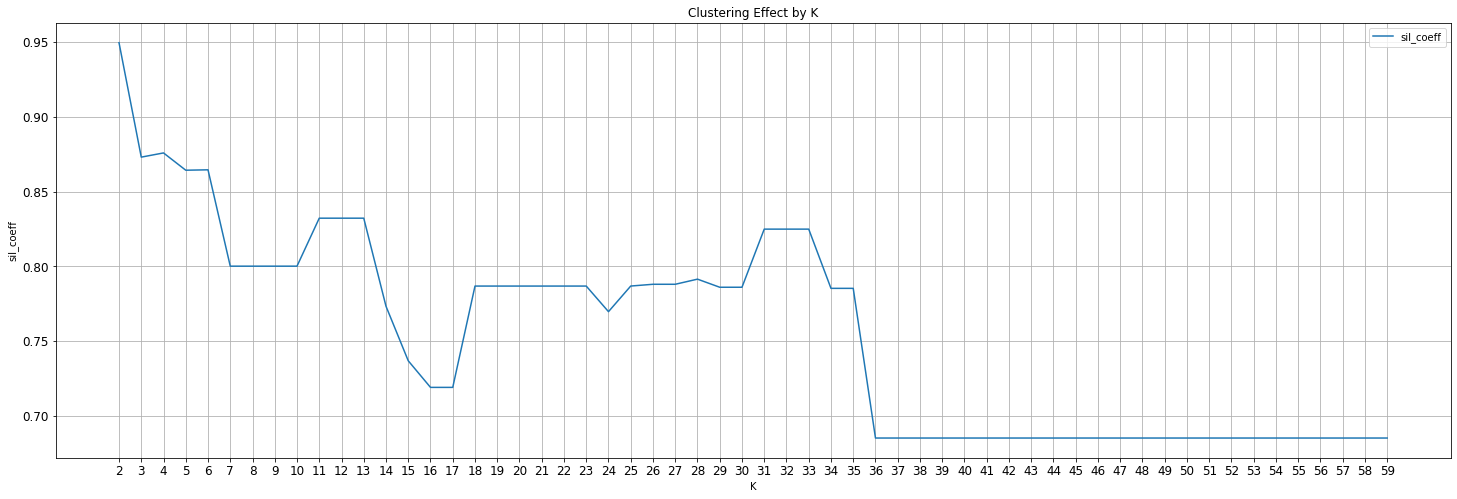

In [20]:
print('**'*10,'Heutristic Machine Learning (PPR + Node2vec-DBSCAN)','**'*10)

# RANKING
PR_index, marker_dict = PR_ranking(df, from_name, to_name, verbose = True)
print('=='*15)

# CLUSTERING
tuning_result = vector_Clustering_exe(df, PR_index,
                                      from_name, to_name, weight_name, from_target_name, to_target_name,
                                      seed_strategy = 'both', 
                                      K_start = K_start, K_end = K_end, K_step = K_step,
                                      verbose = False)
print('**'*10,'宏观实验结果','**'*10)
print('>>> 最优参数组合\n',tuning_result.iloc[0,:])
tuning_result.sort_values('K').plot(x='K',y='sil_coeff', xlabel='K', ylabel='sil_coeff', fontsize=12,
                                    figsize=(25,8), xticks=range(K_start, K_end, K_step), title='Clustering Effect by K',
                                    grid=True)

In [22]:
tuning_result

,K,nx_density,num_nodes,num_edges,num_seeds,expand2seed,D,length,walks,p,q,sil_coeff
0,2,0.068182,33,36,9,1.5556,512,65,10,3.8,0.1,0.949448
2,4,0.072072,37,48,9,2.5556,512,20,15,2.6,0.7,0.875786
1,3,0.069841,36,44,9,2.1111,512,35,10,2.6,0.1,0.872981
4,6,0.072546,38,51,9,3.2222,512,35,15,3.8,1.3,0.864509
3,5,0.075075,37,50,9,2.7778,512,50,10,3.8,0.7,0.864236
10,12,0.069231,40,54,9,4.3333,512,20,10,5.0,1.3,0.832188
11,13,0.069231,40,54,9,4.3333,512,20,10,5.0,1.3,0.832188
9,11,0.069231,40,54,9,4.3333,512,20,10,5.0,1.3,0.832188
31,33,0.042347,58,70,9,5.7778,512,50,5,2.6,0.7,0.824875
30,32,0.042347,58,70,9,5.7778,512,50,5,2.6,0.7,0.824875


### Human Intervention

In [23]:
# MANUALLY CHOOSE THE BEST K
BEST_K = 6 # 同时要平衡聚类效果和捕捉范围

#### Cluster Describtion

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


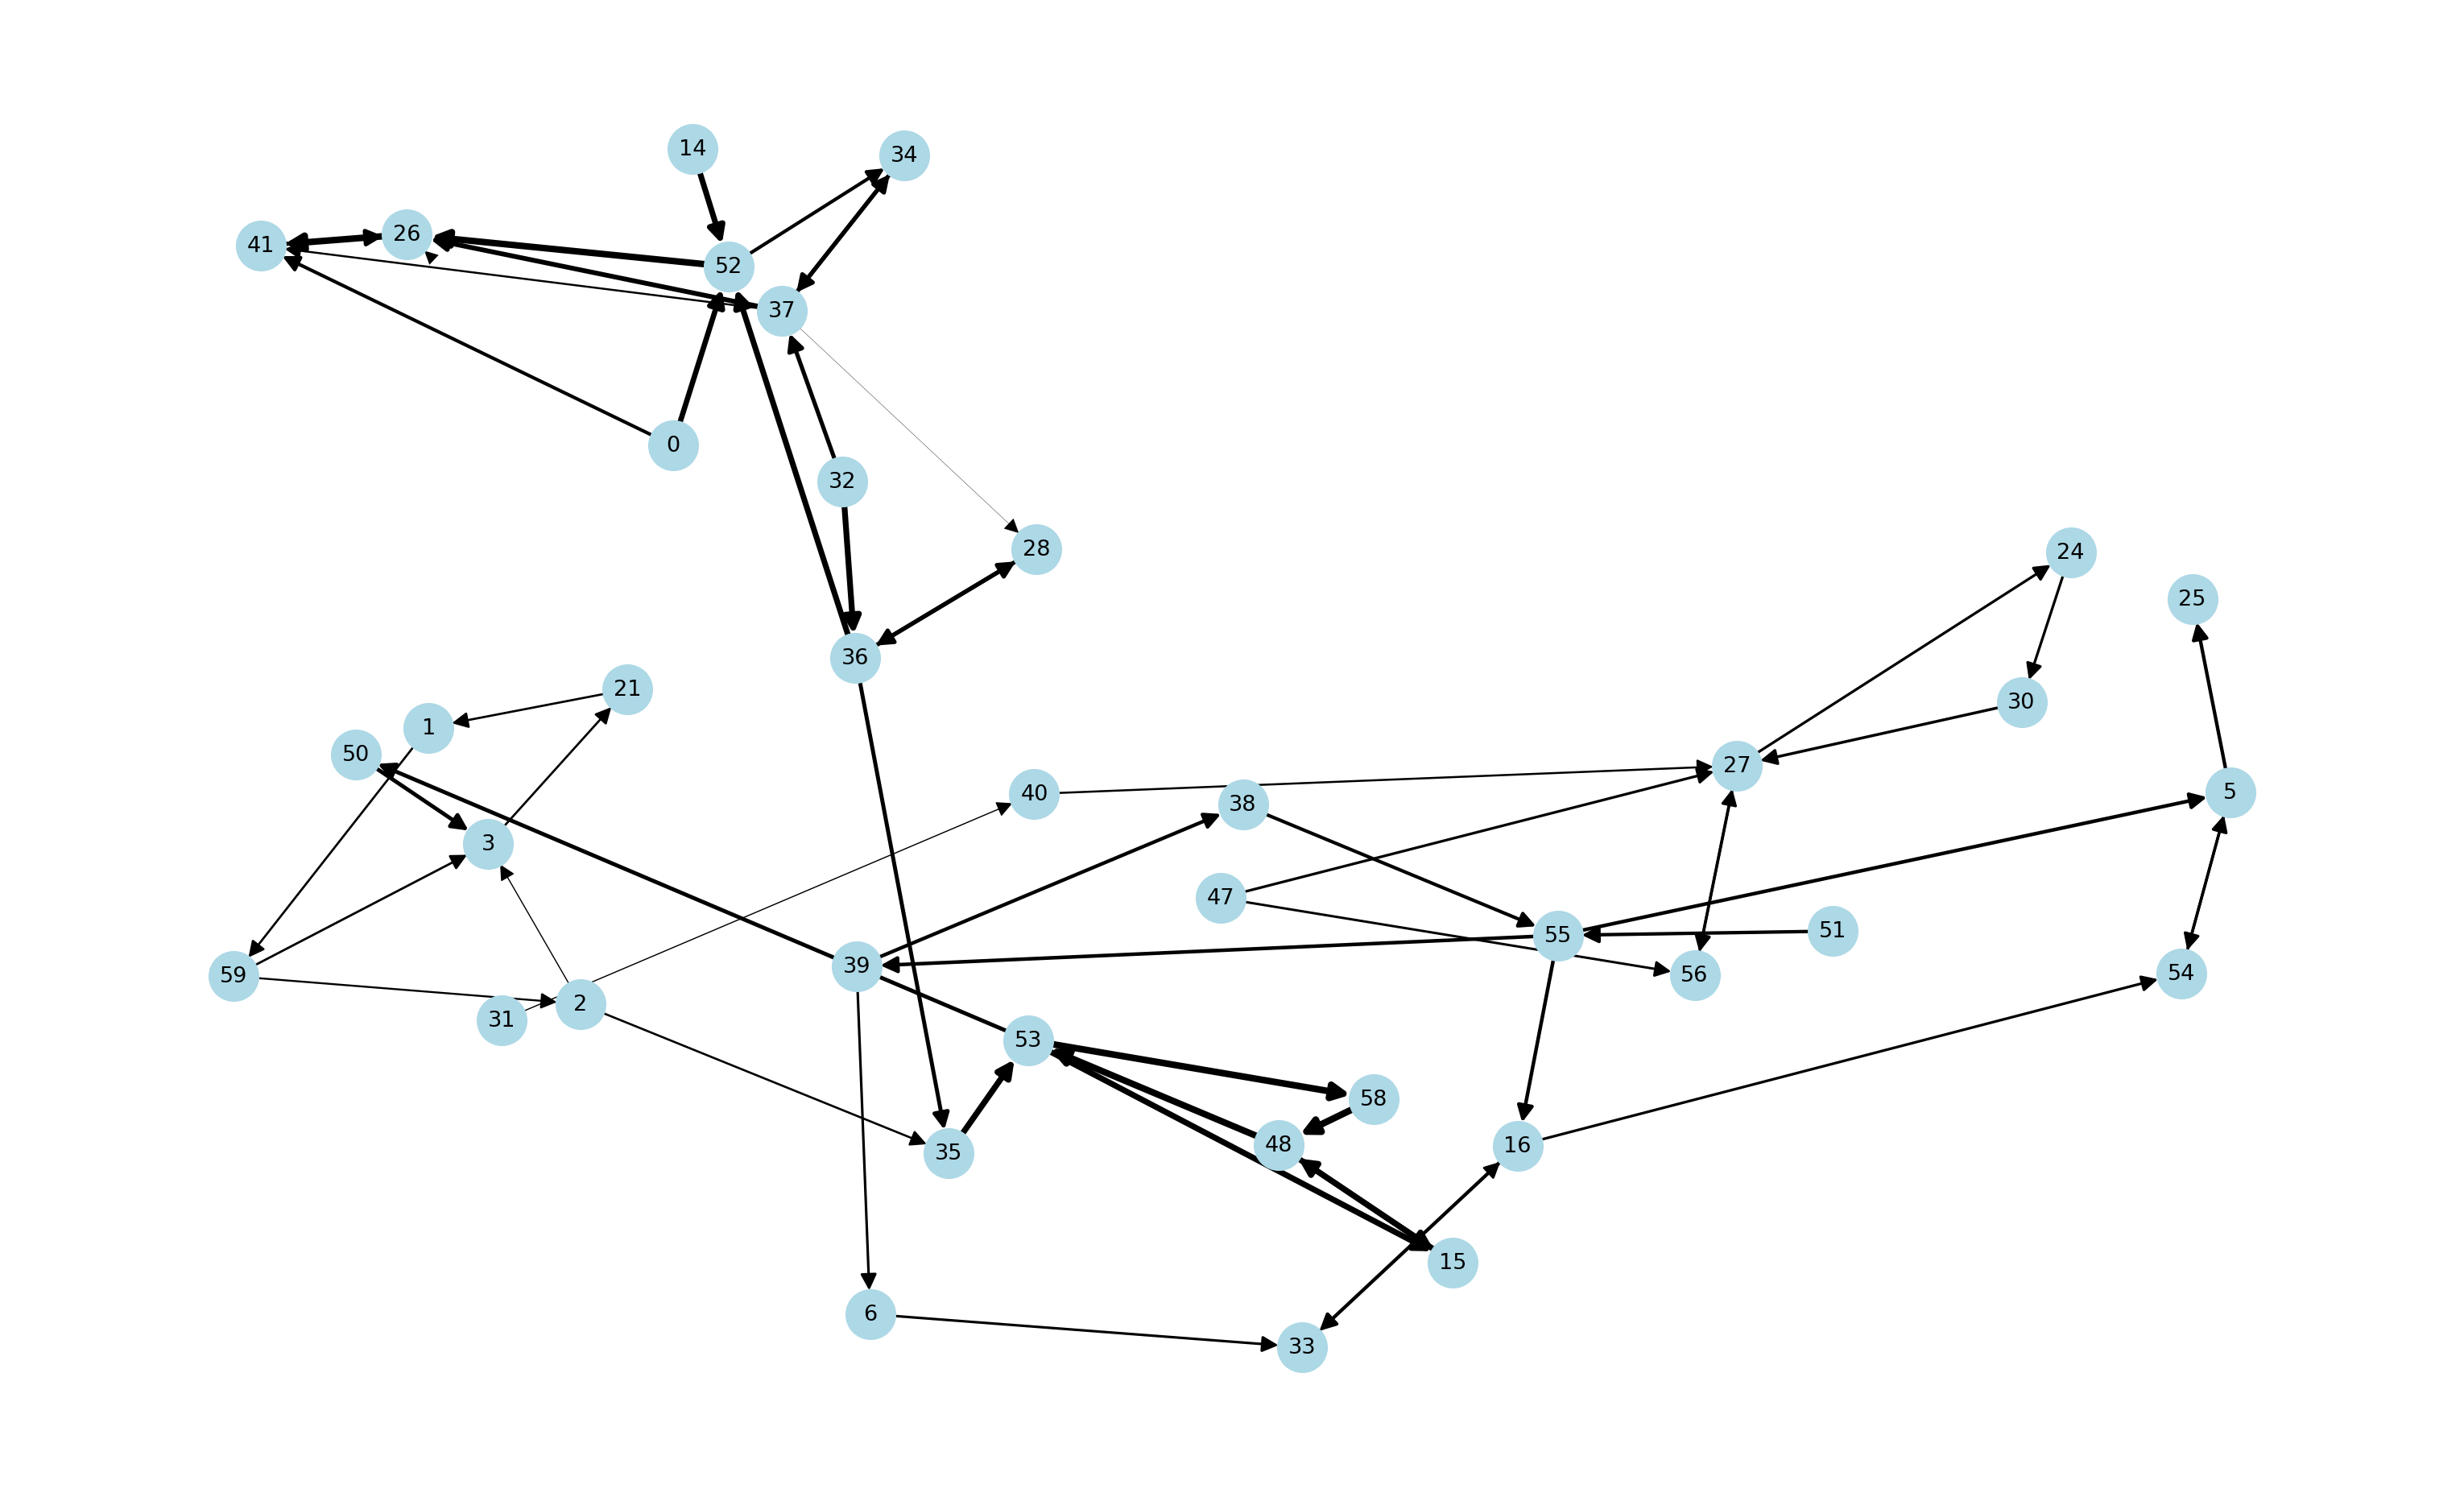

In [24]:
target_df = pd.read_csv(f'results/Top{BEST_K}_n2v_DBSCAN.txt')
G_DESCR = cluster_describtion(target_df, from_name, to_name, weight_name = weight_name,
                              K = BEST_K,
                              visualize_whole = True # 设定是否对全局画图
                              )

>>> 按照出度节点 OR 入度节点属于某个簇的逻辑划分，共有5类团簇...


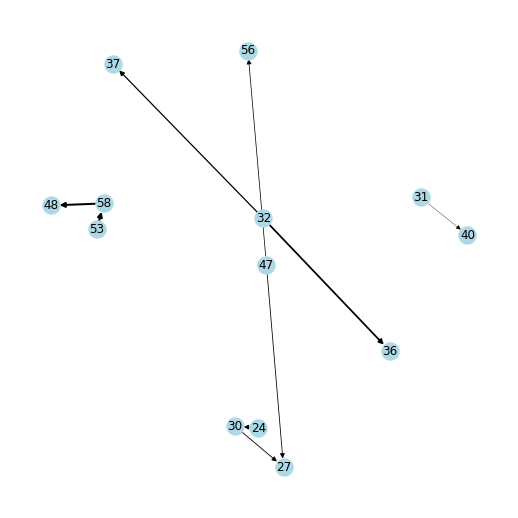

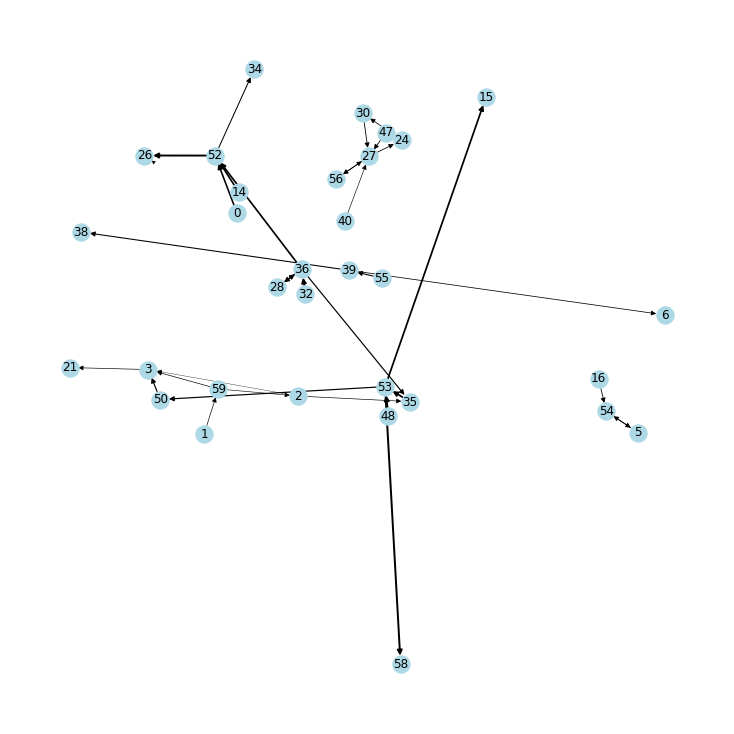

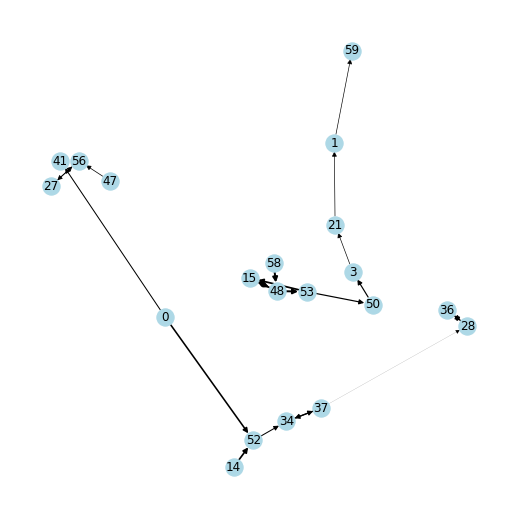

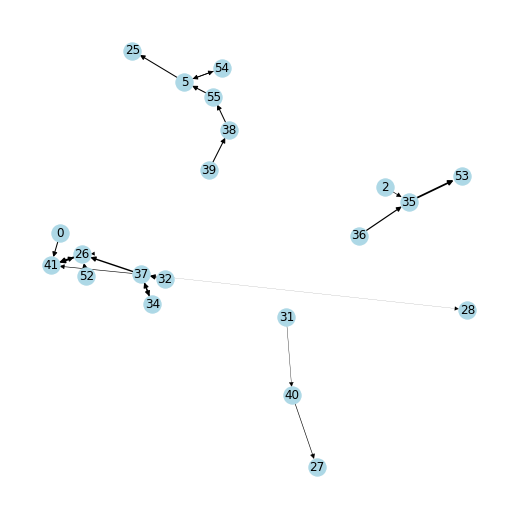

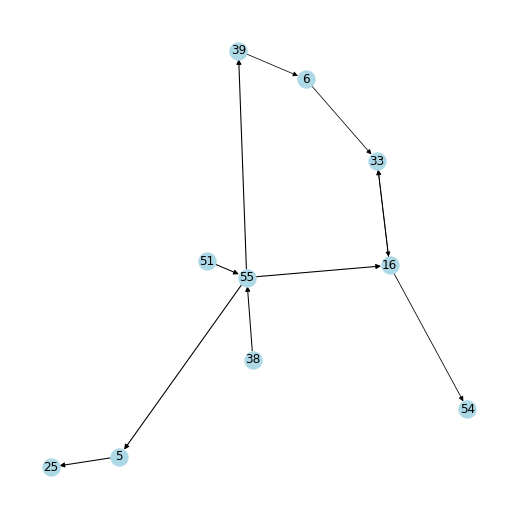

In [25]:
describtion_df = G_DESCR.analyze_each_group()

In [26]:
describtion_df

,cluster_ID,SUS_LIST,density,avg_transitivity,reciprocity,avg_closeness,num_sus_node,avg_amount,avg_degree,avg_indegree,avg_outdegree
0,0,"[47, 27, 30, 56, 24, 31, 40, 32, 37, 36, 58, 4...",0.057692,0.000000,0.000000,0.061432,13,0.580067,0.115385,0.057692,0.057692
1,1,"[47, 27, 30, 56, 40, 24, 14, 52, 0, 36, 26, 28...",0.035282,0.063690,0.171429,0.056797,32,0.534923,0.070565,0.035282,0.035282
2,2,"[56, 27, 47, 14, 52, 0, 41, 36, 28, 37, 34, 48...",0.057895,0.051667,0.363636,0.079696,20,0.594223,0.115789,0.057895,0.057895
3,3,"[40, 27, 31, 0, 41, 37, 26, 36, 52, 28, 35, 2,...",0.052381,0.018216,0.272727,0.068866,21,0.509050,0.104762,0.052381,0.052381
4,4,"[38, 55, 51, 16, 33, 39, 5, 6, 25, 54]",0.122222,0.000000,0.181818,0.201672,10,0.468891,0.244444,0.122222,0.122222


#### Cluster Risk Evaluation

In [27]:
# 风险簇评估
def risk_evaluation(metrics_df, quantile_threshold = 0.5):
    """风险簇评估函数
    
    参数:
        metrics_df (pd.DataFrame): 交易簇网络指标数据框
        quantile_threshold (float, optional): 风险判定分位数阈值，介于(0,1)，默认0.5，越高越严格、筛选出来的高风险簇会更少; 默认0.5
    返回：
        metrics_df（pd.dataFrame)：风险团伙评估与定位数据框
    """
    metrics_df['num_sus_node'] = (metrics_df['num_sus_node'] - metrics_df['num_sus_node'].min()) / (metrics_df['num_sus_node'].max() - metrics_df['num_sus_node'].min()) # 先处理尚未[0,1]标准化的列
    
    metrics_df['CLOSENESS'] = metrics_df[['density', 'avg_transitivity', 'reciprocity']].mean(axis=1)
    metrics_df['SCALE'] = metrics_df[['num_sus_node', 'avg_amount']].mean(axis=1)
    metrics_df['CLOSENESS_RISK'] = np.where(metrics_df['CLOSENESS'] >= metrics_df['CLOSENESS'].quantile(quantile_threshold), 'relatively high', 'relatively low')
    metrics_df['SCALE_RISK'] = np.where(metrics_df['SCALE'] >= metrics_df['SCALE'].quantile(quantile_threshold), 'relatively high', 'relatively low')
    return metrics_df
    

In [28]:
describtion_df = risk_evaluation(describtion_df, quantile_threshold = 0.5)
describtion_df

,cluster_ID,SUS_LIST,density,avg_transitivity,reciprocity,avg_closeness,num_sus_node,avg_amount,avg_degree,avg_indegree,avg_outdegree,CLOSENESS,SCALE,CLOSENESS_RISK,SCALE_RISK
0,0,"[47, 27, 30, 56, 24, 31, 40, 32, 37, 36, 58, 4...",0.057692,0.000000,0.000000,0.061432,0.136364,0.580067,0.115385,0.057692,0.057692,0.019231,0.358215,relatively low,relatively low
1,1,"[47, 27, 30, 56, 40, 24, 14, 52, 0, 36, 26, 28...",0.035282,0.063690,0.171429,0.056797,1.000000,0.534923,0.070565,0.035282,0.035282,0.090134,0.767461,relatively low,relatively high
2,2,"[56, 27, 47, 14, 52, 0, 41, 36, 28, 37, 34, 48...",0.057895,0.051667,0.363636,0.079696,0.454545,0.594223,0.115789,0.057895,0.057895,0.157733,0.524384,relatively high,relatively high
3,3,"[40, 27, 31, 0, 41, 37, 26, 36, 52, 28, 35, 2,...",0.052381,0.018216,0.272727,0.068866,0.500000,0.509050,0.104762,0.052381,0.052381,0.114441,0.504525,relatively high,relatively high
4,4,"[38, 55, 51, 16, 33, 39, 5, 6, 25, 54]",0.122222,0.000000,0.181818,0.201672,0.000000,0.468891,0.244444,0.122222,0.122222,0.101347,0.234445,relatively high,relatively low


In [31]:
describtion_df.sort_values(by=['CLOSENESS','SCALE'], ascending=False)[['cluster_ID', 'SUS_LIST', 'CLOSENESS', 'SCALE']]

,cluster_ID,SUS_LIST,CLOSENESS,SCALE
2,2,"[56, 27, 47, 14, 52, 0, 41, 36, 28, 37, 34, 48...",0.157733,0.524384
3,3,"[40, 27, 31, 0, 41, 37, 26, 36, 52, 28, 35, 2,...",0.114441,0.504525
4,4,"[38, 55, 51, 16, 33, 39, 5, 6, 25, 54]",0.101347,0.234445
1,1,"[47, 27, 30, 56, 40, 24, 14, 52, 0, 36, 26, 28...",0.090134,0.767461
0,0,"[47, 27, 30, 56, 24, 31, 40, 32, 37, 36, 58, 4...",0.019231,0.358215
